In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap
from matplotlib.colors import to_rgba
import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

In [2]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-10-11') 
wave = july18.variables['VHM0'][:]

wave

<xarray.Variable (time: 24, latitude: 47, longitude: 62)>
array([[[0.496, 0.475, ..., 2.179, 2.139],
        [0.389, 0.349, ..., 2.141, 2.102],
        ...,
        [0.365, 0.37 , ...,   nan,   nan],
        [0.358, 0.363, ...,   nan,   nan]],

       [[0.473, 0.454, ..., 2.198, 2.157],
        [0.371, 0.335, ..., 2.159, 2.118],
        ...,
        [0.373, 0.375, ...,   nan,   nan],
        [0.369, 0.371, ...,   nan,   nan]],

       ...,

       [[0.893, 0.879, ..., 1.455, 1.46 ],
        [0.834, 0.803, ..., 1.439, 1.441],
        ...,
        [0.469, 0.47 , ...,   nan,   nan],
        [0.472, 0.471, ...,   nan,   nan]],

       [[0.856, 0.844, ..., 1.469, 1.466],
        [0.794, 0.767, ..., 1.456, 1.448],
        ...,
        [0.438, 0.439, ...,   nan,   nan],
        [0.44 , 0.441, ...,   nan,   nan]]], dtype=float32)
Attributes:
    long_name:         Spectral significant wave height (Hm0)
    standard_name:     sea_surface_wave_significant_height
    units:             m
    type_of_analysis:  spectral analysis
    WMO:               100
    _ChunkSizes:       [   1  380 1307]

In [3]:
# general basemap of Italy configuration space
# basemap for zoom plots
mp = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='i') # f

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp(lon, lat)

x_min, y_min = mp(lons.values[0], lats.values[0]) 
x_max, y_max = mp(lons.values[-1], lats.values[-1])

In [4]:
l = 24
li = 5   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 17  # 15  18    18  17    15  - 17   23   12   12   15   18   15   
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))

<ipython-input-5-b2cd44d5b9f1>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))


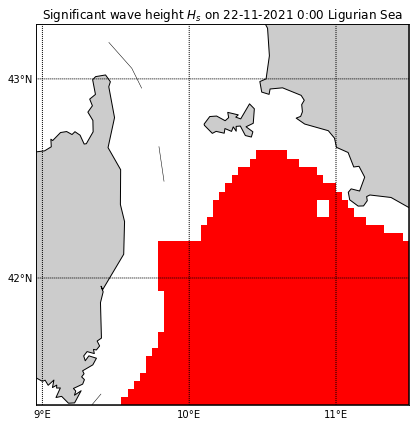

In [5]:
plt.figure(1, figsize=(10, 7))
mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

In [6]:
cost15 = 0
for i in range(len(cost)):
    cost15 += cost[i]
cost15 = 100*(np.array(cost15)>=100)

contour15 = np.logical_xor(cost15,binary_erosion(cost15))

<ipython-input-7-e51ebdf4682c>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')


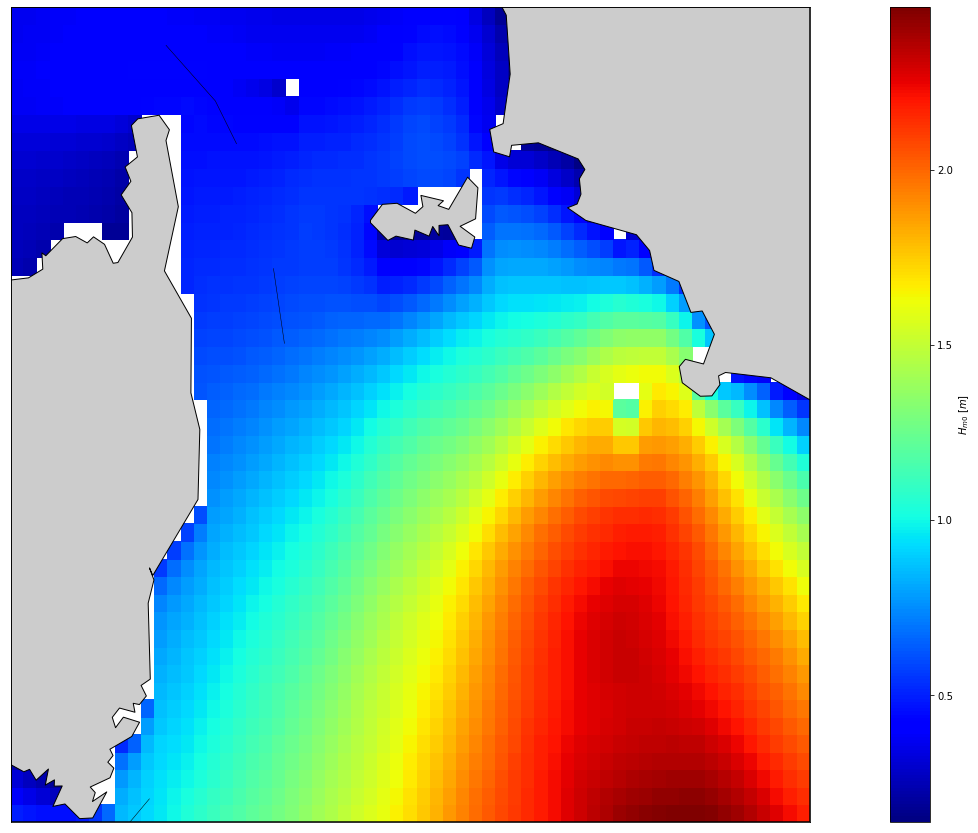

In [7]:
plt.figure(1, figsize=(20, 15))
c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')
# mp.fillcontinents(color='coral',lake_color='aqua')
# mp.plot(s1x, s1y, ">k", markersize=10)
# plt.plot(g1x, g1y, "Xr", markersize=10)
# plt.plot(g2x, g2y, "Xb", markersize=10)
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
# mp.drawmapboundary(fill_color='aqua')
cbar = mp.colorbar(c_scheme, location='right', pad='10%')
cbar.set_label('$H_{m0}$ $[m]$')
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.show()


<ipython-input-8-b2cd44d5b9f1>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))


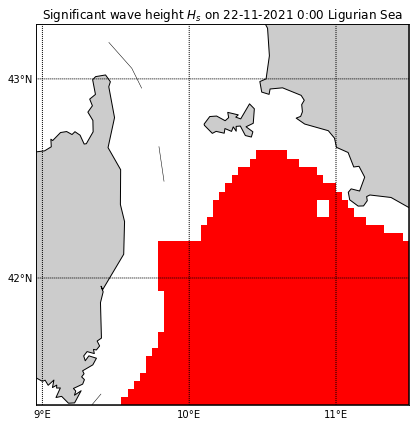

In [8]:
plt.figure(1, figsize=(10, 7))
mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

In [9]:
oxland, oyland = [], []
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []

oxmeteo, oymeteo = [], []     # all meteo points
x_obsm, y_obsm = [], []       # contour meteo points
oxmeteo_, oymeteo_ = [], []   # all meteo points
x_obsm_, y_obsm_ = [], []     # contour meteo points


for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if contour15[k][j]:
            #if lats.values[k] < 42.6:
#             if 9.45< lons.values[j]< 9.46 and 41.64 < lats.values[k] < 41.7:
#                 continue
            x_obsm.append(lons.values[j])
            y_obsm.append(lats.values[k])
x_obsm_, y_obsm_ = mp(x_obsm, y_obsm)       # meteo contour points

# land is always static    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]:
#                     if lons_mask.values[j] > 9.8:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
                    
                        
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points

ox_a_list = []
oy_a_list = []
ox_a_list.extend(x_obsm)
oy_a_list.extend(y_obsm)
# ox_a_list.extend(x_obsl)
# oy_a_list.extend(y_obsl)

In [10]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]   # 9.41        # [12]
sy = yspace[7]    # 43.104168   # [6]
gx = xspace[50]   # 11.291668    39
gy = yspace[28]   # 42.520832    33

sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

In [11]:
grid_size = 0.04166
robot_radius = grid_size

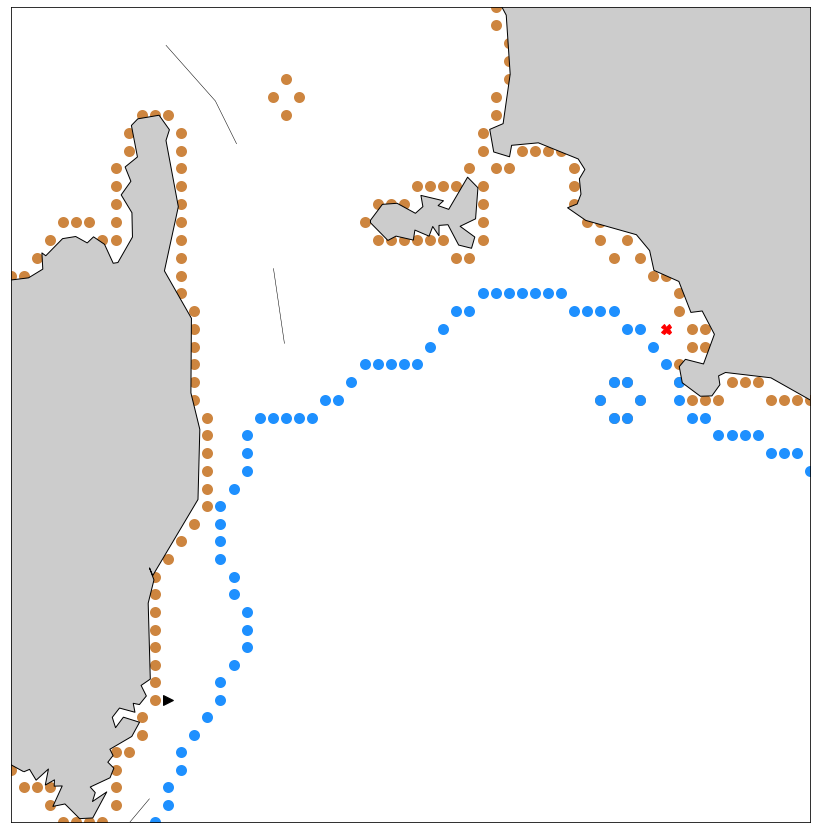

In [12]:
plt.figure(1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.scatter(x_obsl_, y_obsl_, color="peru", linewidth=5)
plt.scatter(x_obsm_, y_obsm_, color="dodgerblue", linewidth=5)
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [49]:
start_time = time.time()
a_star = AStarPlanner(ox_a_list, oy_a_list, grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
rx, ry = a_star.planning(sx, sy, gx, gy)
print("Computational time is {}".format(time.time() - start_time))
rx = list(reversed(rx))
ry = list(reversed(ry))

min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Computational time is 1.5945210456848145


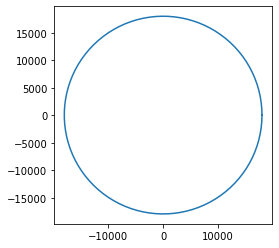

In [13]:
# theta goes from 0 to 2pi
theta = np.linspace(0, 2*np.pi, 100)

# the radius of the circle
r = 18000

# compute x1 and x2
x1 = r*np.cos(theta) + sx
x2 = r*np.sin(theta) + sy

# create the figure
fig, ax = plt.subplots(1)
ax.plot(x1, x2)
ax.set_aspect(1)
plt.show()

In [23]:


import matplotlib.patches as pltpat
hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp(lons.values[-1],lats.values[-1])[0])
pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.5, fill = False)

print(hh, ww)

24369.62094343742 23918.5304863459


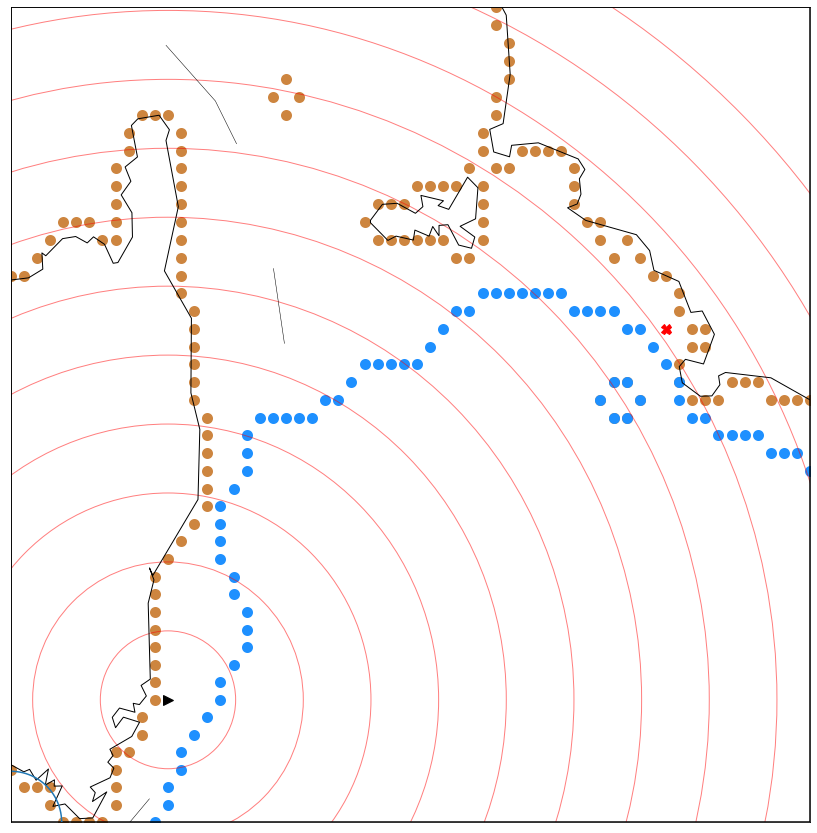

In [22]:
import matplotlib.patches as pltpat
# rx_, ry_ = mp(rx, ry)
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
plt.scatter(x_obsl_, y_obsl_, color="peru", linewidth=5)
plt.scatter(x_obsm_, y_obsm_, color="dodgerblue", linewidth=5)
# for i in range(10):
#     plt.scatter(73000+18000*i, 43295, color="b", linewidth=5)
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(sx_init, sy_init), radius=23918*(i+1),
#                                 color='red', alpha=0.5, fill = False))

for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(sx_init, sy_init),width=2.0 * ww *(i+1), height=2.0 * hh*(i+1),
                                color='red', alpha=0.5, fill = False))
# mp.plot(rx_, ry_, '.r')
ax.plot(x1, x2)
# plt.scatter(rx_star, ry_star, color="g", linewidth=5)
# mp.plot(rx_[:rx_.index(rx_star)+1], ry_[:rx_.index(rx_star)+1], '-b')
#mp.plot(loaded_list[3], loaded_list2[3], '-b')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [134]:
mp(lons.values[-1],lats.values[-1])[1]

288240.94636369497

In [136]:
hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp(lons.values[-1],lats.values[-1])[0])

24394.209712486667


In [95]:
rx_stargeo, ry_stargeo = mp(rx_star,ry_star,inverse=True)

In [82]:
for i in range(len(rx_)):
    for j in range(len(x1)):
        if np.allclose([rx_[i],ry_[i]], [x1[j], x2[j]], atol=0.05, rtol=0.04):
            rx_star = rx_[i]
            ry_star = ry_[i]
            print(True)

True


In [103]:
path_dist = 0
for i in range(rx_.index(rx_star)):
    print(i)
    path_dist += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
    print(distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km)
print("Travel time = ", str(round(path_dist/18,4)), "hours")

0
5.783346606058687
1
4.627077144146434
2
5.780715849295097
Travel time =  0.8995 hours
